## Route ID 172, Operator 127 Test
* Santa Rosa - San Francisco

In [1]:
import geopandas as gpd
import pandas as pd
from calitp.sql import to_snakecase
from shared_utils import geography_utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
GCS_DASK_PATH = "gs://calitp-analytics-data/data-analyses/dask_test/"
GCS_RT_PATH = "gs://calitp-analytics-data/data-analyses/rt_delay/"

In [4]:
analysis_date = "2022-10-12"

In [5]:
agency = 282

In [6]:
route_id = "30"

In [7]:
# Shapes for Route 30
shape_ids_for_route_30 = [
    "204815",
    "204818",
    "204821",
    "204814",
    "204822",
    "204812",
    "204817",
    "204811",
    "204823",
    "204824",
    "204826",
    "204816",
]

### Route Map

In [8]:
# Tells me actual route length for each shape id.
routelines = gpd.read_parquet(
    f"{GCS_RT_PATH}compiled_cached_views/routelines_{analysis_date}.parquet"
)

In [9]:
# Filter for specific route & agency
routelines = (
    routelines[
        (
            (routelines.calitp_itp_id == agency)
            & (routelines.shape_id.isin(shape_ids_for_route_30))
        )
    ]
    .drop(columns=["calitp_url_number"])
    .reset_index(drop=True)
    .drop_duplicates()
)

In [10]:
# Calculate length of geometry
routelines = routelines.assign(
    actual_route_length=(
        routelines.geometry.to_crs(geography_utils.CA_NAD83Albers).length
    )
)

In [11]:
len(routelines)

12

In [12]:
routelines.shape_id.nunique()

12

<AxesSubplot:>

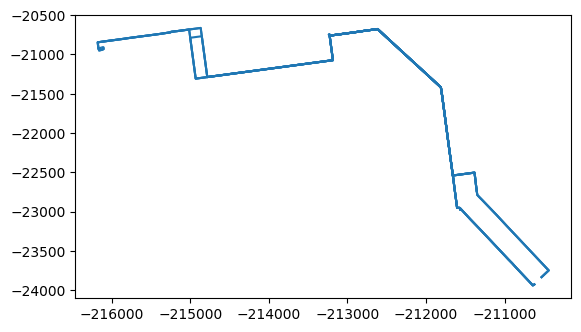

In [13]:
routelines.plot()

### Trip Map
* https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [14]:
trips = pd.read_parquet(
    f"{GCS_RT_PATH}compiled_cached_views/trips_{analysis_date}_v1.parquet"
).drop(columns = ["calitp_url_number", "trip_key"])

In [15]:
trips = trips.assign(
    departure_time=pd.to_datetime(trips.trip_first_departure_ts, unit="s"),
    end_time=pd.to_datetime(trips.trip_last_arrival_ts, unit="s"),
)

In [16]:
# Find only rows for route 30
trips_282 = trips[
    ((trips.calitp_itp_id == agency) & (trips.route_id == route_id))
].reset_index(drop=True)

In [17]:
trips_282.shape

(564, 13)

* `Calitp_deleted_at` is different between the same trip ids.
* `Departure_time` not displaying time? 

In [18]:
trips_282.loc[trips_282.trip_id == '11136193']

,calitp_itp_id,service_date,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,trip_first_departure_ts,trip_last_arrival_ts,service_hours,departure_time,end_time
78,282,2022-10-12,11136193,30,0,204812,2022-09-25,2099-01-01,86400,88560,0.60,1970-01-02,1970-01-02 00:36:00
483,282,2022-10-12,11136193,30,0,204812,2022-09-26,2022-11-17,86400,88560,0.60,1970-01-02,1970-01-02 00:36:00


In [19]:
datetime_cols = [
    "service_date",
    "calitp_extracted_at",
    "calitp_deleted_at",
    "trip_first_departure_ts",
    "trip_last_arrival_ts",
    "service_hours",
    "departure_time",
    "end_time",
]

* After dropping the columns above, the # of rows drops to 282. 

In [20]:
trips_282_no_time = trips_282.drop(columns=datetime_cols)

In [21]:
len(trips_282_no_time.drop_duplicates())

282

In [22]:
trips_282_no_dups = trips_282_no_time.drop_duplicates().reset_index(drop=True)

In [23]:
# Read in crosswalk for route_dir_identifier.
crosswalk = pd.read_parquet(
    f"{GCS_DASK_PATH}segments_route_direction_crosswalk.parquet"
)

In [24]:
# Join to crosswalk before joining routlines to grab geometry
trips_m_crosswalk = trips_282_no_dups.merge(
    crosswalk, how="inner", on=["calitp_itp_id", "route_id", "direction_id"]
)

In [25]:
trips_m_crosswalk.head(2)

,calitp_itp_id,trip_id,route_id,direction_id,shape_id,route_dir_identifier
0,282,11136210,30,0,204815,3971062270
1,282,11136289,30,0,204814,3971062270


In [26]:
# Merge routes for geometry, actual route length,
m1 = routelines.merge(
    trips_m_crosswalk,
    how="inner",
    on=["calitp_itp_id", "shape_id"],
)

#### how many rows in the trips table for that route? when you plot (choosetrip_id column to plot) it on a map, how many do you see?
* 282 trip ids. 
* 232 rows.
* Always plotting shape_id underneath, just the coloring is different.

In [27]:
len(m1)

282

In [28]:
m1.trip_id.nunique()

282

In [29]:
# m1.loc[m1.trip_id == "11136191"]

In [30]:
"""m1.explore(
    "trip_id",
    cmap="tab10",
    style_kwds={"weight": 6},
    height=400,
    width=600,
    legend=False,
)"""

'm1.explore(\n    "trip_id",\n    cmap="tab10",\n    style_kwds={"weight": 6},\n    height=400,\n    width=600,\n    legend=False,\n)'

#### how many unique route_ids? when you plot route_id on a map, how many do you see?
* Just one for both questions.

In [31]:
m1.route_id.nunique()

1

In [32]:
"""m1.explore(
    "route_id",
    cmap="tab10",
    style_kwds={"weight": 6},
    height=400,
    width=600,
    legend=True,
)"""

'm1.explore(\n    "route_id",\n    cmap="tab10",\n    style_kwds={"weight": 6},\n    height=400,\n    width=600,\n    legend=True,\n)'

In [33]:
# m1.loc[m1.route_dir_identifier == 483822386].explore("trip_id",cmap = 'tab10', style_kwds = {'weight':6}, height=400, width = 600, legend  = True)

In [34]:
# m1.loc[m1.route_dir_identifier == 1808907172].explore("trip_id",cmap = 'tab10', style_kwds = {'weight':6}, height=400, width = 600, legend  = True)

### Shapes 
* Direction 1: going towards Financial District.
* Direction 0: going towards Presidio.

In [35]:
longest_shape = gpd.read_parquet(f"{GCS_DASK_PATH}longest_shape_segments.parquet")

In [36]:
longest_shape.drop(columns=["geometry", "geometry_arrowized"]).sample(5)

,calitp_itp_id,calitp_url_number,route_id,direction_id,longest_shape_id,route_dir_identifier,route_length,segment_sequence
124539,474,0,C40,0,p_499962,3754085292,48475.01,45
4075,4,0,V,1,shp-V-07,1629253302,26678.73,1
55956,226,0,308,0,3080067,854638093,30753.61,27
1110,4,0,605,1,shp-605-01,2420599098,15876.60,0
9069,48,0,8eb7348e-e35c-4c55-84e8-6d9ea4bfa017,0,5e310d4c-e4b7-4fc8-909f-adf61a956f1b,3409065998,11821.71,10


In [37]:
m2 = (m1.drop(columns=["geometry"]).merge(
        longest_shape,
        how="inner",
        on=["calitp_itp_id", "direction_id", "route_id", "route_dir_identifier"],
    )
    .drop_duplicates()
    .reset_index(drop=True)
)

In [38]:
len(m2)

1410

In [39]:
m2["longest_vs_actual_route"] = m2.actual_route_length / m2.route_length * 100

In [40]:
m3 = m2.set_geometry("geometry_arrowized")

In [41]:
m3.drop(columns=["geometry", "geometry_arrowized"]).head(2)

,calitp_itp_id,shape_id,actual_route_length,trip_id,route_id,direction_id,route_dir_identifier,calitp_url_number,longest_shape_id,route_length,segment_sequence,longest_vs_actual_route
0,282,204812,8141.77,11136194,30,0,3971062270,0,204811,3415.07,0,238.41
1,282,204812,8141.77,11136194,30,0,3971062270,0,204811,3415.07,1,238.41


In [42]:
type(m3), type(m2)

(geopandas.geodataframe.GeoDataFrame, pandas.core.frame.DataFrame)

#### How many unique shape_ids? when you plot shape_id on a map, how many do you see?
* 12 shape ids.
* I can see 2 shape ids on the map (barely).
* However, all 12 are plotted.

In [43]:
m3.shape_id.nunique()

12

In [44]:
"""m3.explore(
    "shape_id",
    cmap="tab10",
    style_kwds={"weight": 6},
    legend=True,
    width=800,
    height=400,
)"""

'm3.explore(\n    "shape_id",\n    cmap="tab10",\n    style_kwds={"weight": 6},\n    legend=True,\n    width=800,\n    height=400,\n)'

In [45]:
"""m3.loc[m3.shape_id == "204821"].explore(
    "shape_id",
    cmap="tab10",
    style_kwds={"weight": 6},
    legend=True,
    width=800,
    height=400,
)"""

'm3.loc[m3.shape_id == "204821"].explore(\n    "shape_id",\n    cmap="tab10",\n    style_kwds={"weight": 6},\n    legend=True,\n    width=800,\n    height=400,\n)'

#### how many unique direction_ids? when you plot direction_id, how many do you see?
* 2 direction ids. 
* Looks a lot like what happens when plotting on `shape_id` column.

In [46]:
m3.direction_id.nunique()

2

In [47]:
"""m3.explore(
    "direction_id",
    cmap="tab10",
    style_kwds={"weight": 6},
    legend=True,
    width=800,
    height=400,
)"""

'm3.explore(\n    "direction_id",\n    cmap="tab10",\n    style_kwds={"weight": 6},\n    legend=True,\n    width=800,\n    height=400,\n)'

In [48]:
"""
m3.explore(
    "segment_sequence",
    cmap="tab10",
    style_kwds={"weight": 6},
    legend=False,
    width=800,
    height=400,
)"""

'\nm3.explore(\n    "segment_sequence",\n    cmap="tab10",\n    style_kwds={"weight": 6},\n    legend=False,\n    width=800,\n    height=400,\n)'

In [49]:
# m3.loc[m3.direction_id == "0"].explore("segment_sequence", cmap = 'tab10', style_kwds = {'weight':6}, legend = False, width = 800, height = 400)

In [50]:
# m3.loc[m3.direction_id == "1"].explore("segment_sequence", cmap = 'tab20', style_kwds = {'weight':6}, legend = False, width = 800, height = 400)

In [51]:
def find_operator_info(df):
    df = df.sort_values(["calitp_itp_id", "trip_id", "segment_sequence"])

    merge_cols = [
        "calitp_itp_id",
        "trip_id",
        "route_dir_identifier",
    ]

    # Get start time.
    start_time_trip = (
        df.groupby(merge_cols)
        .agg({"vehicle_timestamp": "min"})
        .rename(columns={"vehicle_timestamp": "start"})
        .reset_index()
    )

    # Get end time.
    end_time_trip = (
        df.groupby(merge_cols)
        .agg({"vehicle_timestamp": "max"})
        .rename(columns={"vehicle_timestamp": "end"})
        .reset_index()
    )

    # Count number of segments.
    segment_counts = (
        df.groupby(merge_cols)
        .agg({"segment_sequence": "nunique"})
        .reset_index()
        .rename(columns={"segment_sequence": "number_of_segments"})
    )

    # Merge
    m1 = start_time_trip.merge(end_time_trip, how="inner", on=merge_cols).merge(
        segment_counts, how="left", on=merge_cols
    )

    # Calculate time elapsed
    # https://stackoverflow.com/questions/51491724/calculate-difference-of-2-dates-in-minutes-in-pandas
    m1["minutes_elapsed"] = (m1.end - m1.start).dt.total_seconds() / 60

    return m1

In [52]:
# Use pandas.read_parquet/read_feather() instead.
operator = pd.read_parquet(
    f"{GCS_DASK_PATH}vp_sjoin/vp_segment_{agency}_{analysis_date}.parquet"
)

In [53]:
operator_info = find_operator_info(operator)

In [54]:
len(operator_info)

8518

In [55]:
operator_info.head()

,calitp_itp_id,trip_id,route_dir_identifier,start,end,number_of_segments,minutes_elapsed
0,282,11108746,4013410901,2022-10-12 15:05:36,2022-10-12 15:47:45,9,42.15
1,282,11108747,4013410901,2022-10-12 14:57:24,2022-10-12 15:41:44,9,44.33
2,282,11108748,4013410901,2022-10-12 14:49:23,2022-10-12 15:31:16,10,41.88
3,282,11108749,4013410901,2022-10-12 14:45:02,2022-10-12 15:27:16,10,42.23
4,282,11108750,4013410901,2022-10-12 14:36:35,2022-10-12 15:23:40,9,47.08


In [56]:
# Count number of segments in `longest_shape`.
m3_test = (
    m3.groupby(
        [
            "calitp_itp_id",
            "trip_id",
            "route_dir_identifier",
            "shape_id",
            "longest_shape_id",
            "longest_vs_actual_route",
        ]
    )
    .agg({"segment_sequence": "count"})
    .rename(columns = {'segment_sequence':'total_segments'})
    .reset_index()
)

In [57]:
m3_test.head()

,calitp_itp_id,trip_id,route_dir_identifier,shape_id,longest_shape_id,longest_vs_actual_route,total_segments
0,282,11136191,3971062270,204811,204811,100.00,4
1,282,11136192,3971062270,204814,204811,143.93,4
2,282,11136193,3971062270,204812,204811,238.41,4
3,282,11136194,3971062270,204812,204811,238.41,4
4,282,11136195,3971062270,204812,204811,238.41,4


In [59]:
# Merge 
m4 = operator_info[
    [
        "calitp_itp_id",
        "trip_id",
        "route_dir_identifier",
        "number_of_segments",
        "minutes_elapsed",
    ]
].merge(
    m3_test,
    how="inner",
    on=["calitp_itp_id", "trip_id", "route_dir_identifier"],
)

#### Help: normal for trip_ids to be dropped? Why are the `longest_vs_actual_route` so funky?

In [60]:
m4.shape

(279, 9)

In [64]:
m4.trip_id.nunique()

279

In [61]:
# Find the total number of segments in the specific operator file
# vs. what was recorded in `longest_shape`
m4["segment_proportion"] = ((m4.number_of_segments / m4.total_segments) * 100).astype(
    "int64"
)

In [62]:
m4.longest_shape_id.nunique(), m4.shape_id.nunique()

(2, 12)

In [63]:
m4.sample(10)

,calitp_itp_id,trip_id,route_dir_identifier,number_of_segments,minutes_elapsed,shape_id,longest_shape_id,longest_vs_actual_route,total_segments,segment_proportion
55,282,11136247,3971062270,4,21.15,204815,204811,262.49,4,100
200,282,11136393,2612439400,4,23.08,204821,204817,89.02,6,66
121,282,11136313,3971062270,4,21.07,204814,204811,143.93,4,100
245,282,11136439,2612439400,5,24.57,204824,204817,139.59,6,83
202,282,11136395,2612439400,4,22.25,204821,204817,89.02,6,66
82,282,11136274,3971062270,4,24.25,204815,204811,262.49,4,100
134,282,11136326,3971062270,4,18.02,204814,204811,143.93,4,100
218,282,11136411,2612439400,4,21.18,204821,204817,89.02,6,66
84,282,11136276,3971062270,4,20.72,204815,204811,262.49,4,100
263,282,11136457,2612439400,6,31.58,204822,204817,165.26,6,100
